# Comparison of heuristic-based methods and LSTM
Here we compare performance of the best LSTM model against the heuristic-based methods (velocity-based and coordinte-based). We create plots for the paper.

In [1]:
%matplotlib inline
%pylab inline
from keras.models import load_model
import keras
import math
from numpy import mean
from utils import *

# We use 'weighted_binary_crossentropy' which might not be originaly available in keras. Add it
keras.losses.weighted_binary_crossentropy = weighted_binary_crossentropy

Populating the interactive namespace from numpy and matplotlib


/home/lukasz/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Set up directories, dimensions of models and load the data

In [2]:
# Settings
input_dim = 99
output_dim = 0
nseqlen = 128
test_dir = "/media/lukasz/DATA/test"

# Load data
inputs, outputs, ids = load_data(test_dir, input_dim, 2, nseqlen, nsamples = 10000)

# Figure out dimensions
n = inputs.shape[0]
ntrain = int(math.floor(n * 0.9))

## Plot training histories of all models

model-1-32-2.json 0.00279647722752


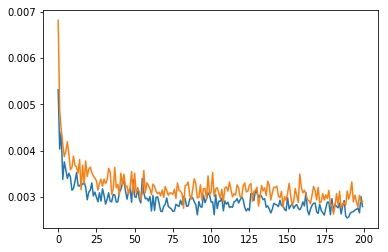

model-1-64-0.json 0.00277869508041


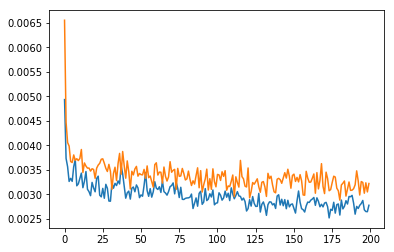

model-1-32-0.json 0.00271450562644


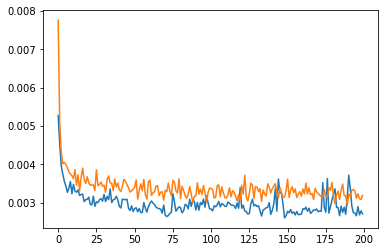

model-0-64-0.json 0.00367125686577


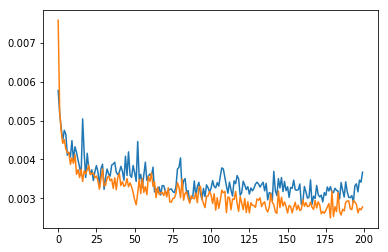

model-1-64-2.json 0.00280946574345


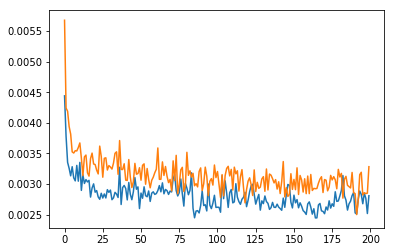

model-0-32-2.json 0.00299486010762


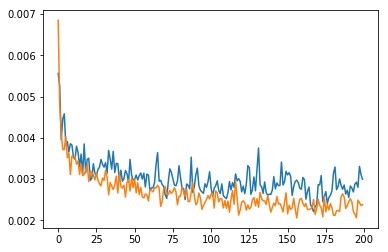

model-1-16-0.json 0.00285506696775


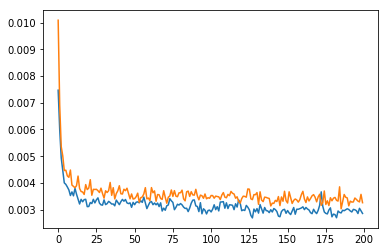

model-0-64-1.json 0.00310597603914


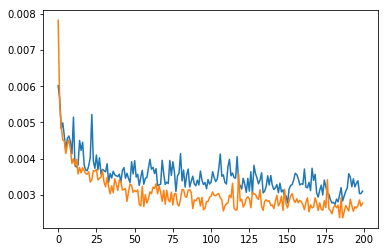

model-0-32-0.json 0.00307400964102


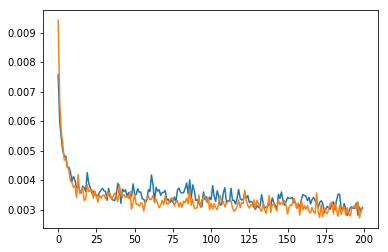

model-1-64-1.json 0.00289159366918


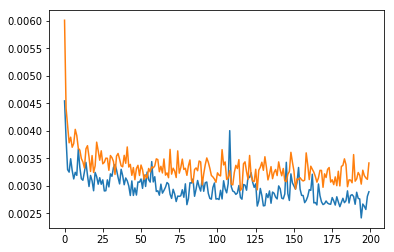

model-0-64-2.json 0.00272441926509


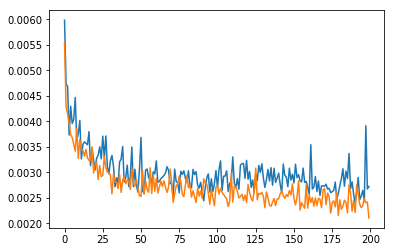

model-1-32-1.json 0.00272816337093


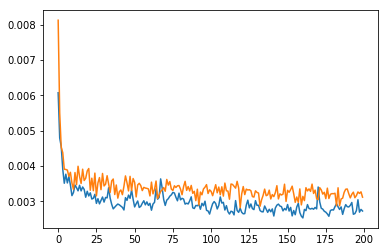

model-1-16-2.json 0.0027433118187


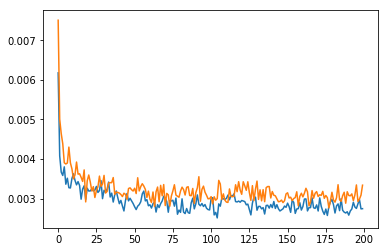

model-0-32-1.json 0.00346934313738


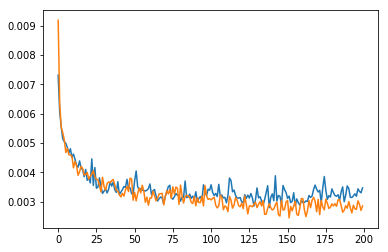

model-0-16-2.json 0.00246427757064


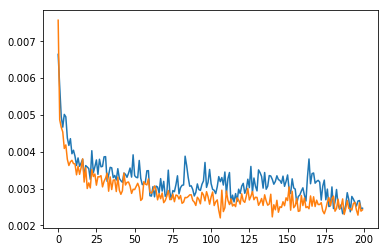

model-0-16-0.json 0.00342770357334


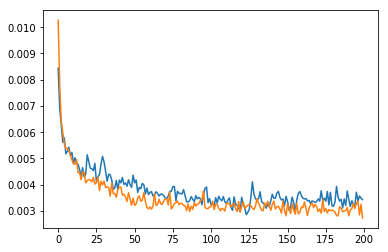

model-0-16-1.json 0.00444163509282


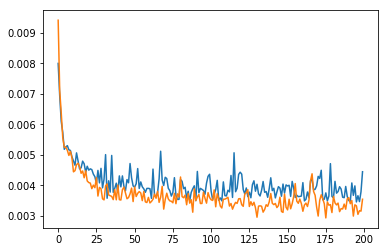

model-1-16-1.json 0.00370132776166


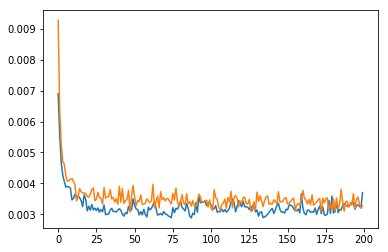

In [3]:
output_dim = 0
for filename in os.listdir("models"):
    if not filename.endswith(".json"): 
        continue
    import json
    with open("models/" + filename, 'r') as infile:
        data = json.load(infile)
        print("%s %s" % (filename, data["history"]["val_loss"][-1]))
        plt.plot(data["history"]["val_loss"])
        plt.plot(data["history"]["loss"])
        plt.show()

64-2 seems to be performing the best so we pick that one.

## Analyze performance of the top model 

In [4]:
model = load_model("models/model-%d-64-2.h5" % output_dim)

/home/lukasz/anaconda2/lib/python2.7/site-packages/Keras-2.0.8-py2.7.egg/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Error distribution:
<= 1: 0.744711
<= 3: 0.944288
<= 5: 0.975317
<= 10: 0.996474
<= 60: 1.000000
Mean distance: 1.208745
0.0200414651002


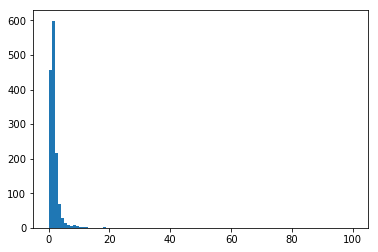

In [5]:
cols = range(15) + [60 + i for i in range(13)] + [12 + 81 + i for i in range(6)]
res = model.predict(inputs[0:ntrain,:,cols])
sdist = []

for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,(output_dim):(output_dim+1)]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 0)
    sdist.extend(d)
plot_stats(sdist)
print(len([k for k in sdist if ((k > 30) or (k < 0))]) / float(len(sdist)))

sdist_our = sdist

## Analyze performance of heuristic based models

--------------------------
Velocity-based predictions
--------------------------
Error distribution:
<= 1: 0.406227
<= 3: 0.758340
<= 5: 0.922165
<= 10: 0.986657
<= 60: 1.000000
Mean distance: 2.457376
0.0677263303386
----------------------------
Coordinate-based predictions
----------------------------
Error distribution:
<= 1: 0.456771
<= 3: 0.830145
<= 5: 0.941086
<= 10: 0.987758
<= 60: 1.000000
Mean distance: 2.177506
0.0967519004838


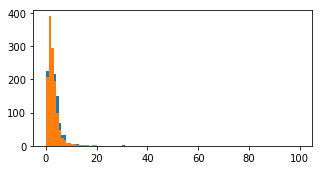

In [9]:
from heuristics import *

res = velocity_pred(inputs, 128, output_dim)
sdist = []
for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,(output_dim):(output_dim+1)]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 3)
    sdist.extend(d)
print("--------------------------")
print("Velocity-based predictions")
print("--------------------------")
plot_stats(sdist)

def coordinate_pred(inputs, nseqlen, output_dim = 0):
    outputs = np.zeros((inputs.shape[0], inputs.shape[1], 1))

    for i in range(inputs.shape[0]):
        try:
            if output_dim == 0:
                peaks = peakdet(inputs[i][:,42],0.5)[0]
                index, value = max(enumerate(peaks), key=lambda x: x[1][1])
            if output_dim == 1:
                peaks = peakdet(inputs[i][:,42],0.5)[1]
                index, value = max(enumerate(peaks), key=lambda x: x[1][1])
            
            
            outputs[i,int(peaks[index][0]),0] = 1
        except:
            pass
        
    return outputs

print(len([k for k in sdist if ((k > 30) or (k < 0))]) / float(len(sdist)))

res = coordinate_pred(inputs, 128, output_dim)
sdist = []
for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,(output_dim):(output_dim+1)]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 3)
    sdist.extend(d)
print("----------------------------")
print("Coordinate-based predictions")
print("----------------------------")
plot_stats(sdist)
print(len([k for k in sdist if ((k > 30) or (k < 0))]) / float(len(sdist)))

## Plot the comparison of methods

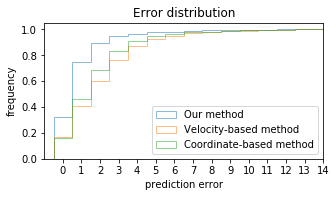

In [10]:
axes = plt.gca()
axes.set_xlim([-1,12])

plt.rcParams['figure.figsize'] = (5, 2.5)
plot_stats_step(sdist_our,name="Our method")

res = velocity_pred(inputs, 128, output_dim)
sdist = []
for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,(output_dim):(output_dim+1)]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 3)
    sdist.extend(d)
plot_stats_step(sdist,name="Velocity-based method")
sdist_vel = sdist

res = coordinate_pred(inputs, 128, output_dim)
sdist = []
for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,(output_dim):(output_dim+1)]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 3)
    sdist.extend(d)
plot_stats_step(sdist,name="Coordinate-based method")
sdist_coo = sdist

xint = range(15)

# Prapare the plot
plt.xticks(xint)
plt.title("Error distribution")
plt.ylabel('frequency')
plt.xlabel('prediction error')
plt.legend(loc='lower right')

mpl.rc("savefig", dpi=300)
savefig("results.png", bbox_inches='tight')

## Find cases where our method finds something that the other methods didn't find

In [11]:
for k,v in enumerate(sdist_coo):
    if v == -1 and sdist_vel[k] == -1 and sdist_our[k] >= 0:
        print (k, ids[k], sdist_our[k])

(2, 'L12123_82.csv', 8.0)
(6, 'L15696_15.csv', 0.0)
(31, 'L15604_67.csv', 4.0)
(40, 'L12518_22.csv', 1.0)
(53, 'L12187_34.csv', 1.0)
(60, 'R13550_16.csv', 0.0)
(117, 'L15029_13.csv', 1.0)
(163, 'R12518_22.csv', 0.0)
(165, 'R13777_46.csv', 1.0)
(179, 'R13761_13.csv', 1.0)
(191, 'R11847_22.csv', 1.0)
(196, 'L13567_23.csv', 1.0)
(205, 'L11583_34.csv', 2.0)
(214, 'L11583_36.csv', 5.0)
(222, 'L12690_17.csv', 1.0)
(324, 'L11752_9.csv', 0)
(380, 'L11792_62.csv', 1.0)
(393, 'R15625_5.csv', 4.0)
(398, 'R14906_13.csv', 2.0)
(434, 'R15421_13.csv', 9.0)
(468, 'L13777_43.csv', 0)
(470, 'R12191_28.csv', 2.0)
(489, 'L9553_31.csv', 2.0)
(498, 'R14991_25.csv', 3.0)
(514, 'L15410_34.csv', 1.0)
(535, 'L14906_13.csv', 0.0)
(605, 'L15108_89.csv', 4.0)
(607, 'L11792_61.csv', 3.0)
(615, 'R12321_57.csv', 0)
(657, 'L14722_16.csv', 2.0)
(671, 'L12191_28.csv', 2.0)
(712, 'R11792_62.csv', 1.0)
(726, 'R9553_29.csv', 1.0)
(754, 'L15744_43.csv', 0)
(761, 'R11583_34.csv', 1.0)
(799, 'L14991_25.csv', 1.0)
(804, 'L1184